In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_tuner import RandomSearch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
df_train = pd.read_csv('dataset/datd_train.csv')
df_test = pd.read_csv('dataset/datd_test.csv')

In [3]:
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

Pre-Processing

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

#inisialisasi stopwords
stop_words = set(stopwords.words('indonesian'))

#inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\binta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\binta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
indo_slang_word = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
normalization_dict = dict(zip(indo_slang_word['slang'], indo_slang_word['formal']))

In [6]:
def normalize_text(text):
    # Tokenisasi kata
    words = word_tokenize(text)
    
    # Ganti kata tidak baku dengan kata baku menggunakan kamus normalisasi
    normalized_words = [normalization_dict.get(word, word) for word in words]
    
    return ' '.join(normalized_words)

In [7]:
def clean_text(text):
    # Ubah teks menjadi huruf kecil (case folding)
    text = text.lower()
    
    # Normalisasi teks
    text = normalize_text(text)
    
    # Hapus teks dalam tanda kurung []
    text = re.sub(r'\[.*?\]', '', text)
    
    # Hapus simbol, angka, dan karakter spesial
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenisasi kata
    words = word_tokenize(text)
    
    # Hapus stopwords
    words = [word for word in words if word not in stop_words]
    
    # Stemming kata
    words = [stemmer.stem(word) for word in words]
    
    # Gabungkan kembali kata-kata menjadi satu string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [8]:
# Terapkan fungsi pembersihan pada kolom 'text'
df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

# Lihat hasil
print(df_train[['text', 'cleaned_text']].head())
print(df_test[['text', 'cleaned_text']].head())

                                                text  \
0  oh pantesan tadi pada rame, ternyata monek mau...   
1       Semakin bertambah usia, semakin cemas hidup.   
2                                 gelisah bgt astaga   
3  Udah jangan terlalu cemas sikapku tak berubah ...   
4  Giliran Aldebaran diambang kematian...Semua ba...   

                                        cleaned_text  
0         oh pantesan rame monek coba juni cemas tuh  
1                            tambah usia cemas hidup  
2                              gelisah banget astaga  
3                          cemas sikap ubah ikut mau  
4  gilir aldebaran ambang mati ulang ya delay nya...  
                                                text  \
0  ngga enak bgt akhir2 ini rasanya, sering cemas...   
1                    Sedikit khawatir dan gelisah. 😓   
2  Ngelakuin kesalahan yang sama. Bodoh bgt. Udah...   
3        Pantesan gelisah bae, lupa lgi ga ada duit🤭   
4  Semoga Mei disertai kabar-kabar baik. Yang luk... 

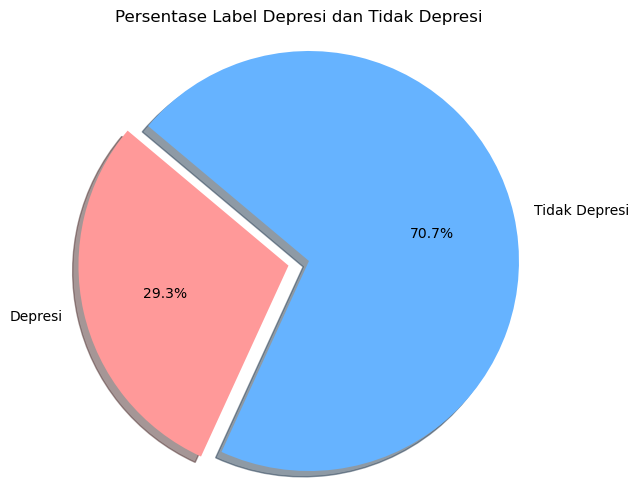

In [9]:
# Hitung jumlah data dengan label depresi (1) dan tidak depresi (0)
count_depresi = df_test[df_test['label'] == 1].shape[0]
count_tidak_depresi = df_test[df_test['label'] == 0].shape[0]

# Buat pie chart
labels = 'Depresi', 'Tidak Depresi'
sizes = [count_depresi, count_tidak_depresi]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # Pisahkan potongan untuk label 'Depresi'

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Agar lingkaran terlihat sebagai lingkaran
plt.title('Persentase Label Depresi dan Tidak Depresi')
plt.show()

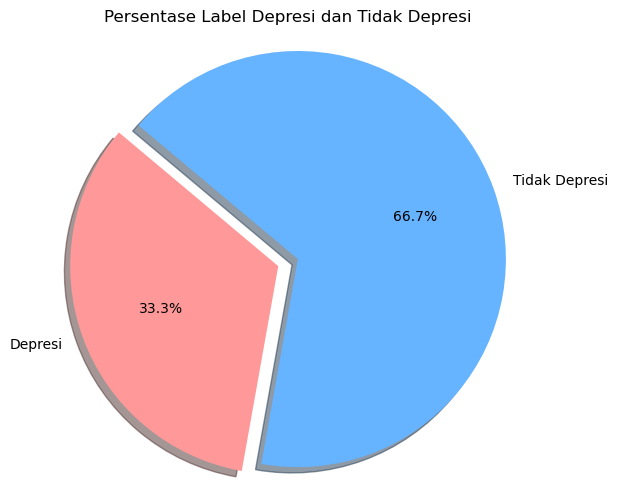

In [10]:
# Hitung jumlah data dengan label depresi (1) dan tidak depresi (0)
count_depresi = df_train[df_train['label'] == 1].shape[0]
count_tidak_depresi = df_train[df_train['label'] == 0].shape[0]

# Buat pie chart
labels = 'Depresi', 'Tidak Depresi'
sizes = [count_depresi, count_tidak_depresi]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # Pisahkan potongan untuk label 'Depresi'

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Agar lingkaran terlihat sebagai lingkaran
plt.title('Persentase Label Depresi dan Tidak Depresi')
plt.show()

In [11]:
X_train = df_train['cleaned_text']
X_test = df_test['cleaned_text']
y_train = df_train['label']
y_test = df_test['label']

In [12]:
df_train

,text,label,cleaned_text
0,"oh pantesan tadi pada rame, ternyata monek mau...",0,oh pantesan rame monek coba juni cemas tuh
1,"Semakin bertambah usia, semakin cemas hidup.",0,tambah usia cemas hidup
2,gelisah bgt astaga,1,gelisah banget astaga
3,Udah jangan terlalu cemas sikapku tak berubah ...,0,cemas sikap ubah ikut mau
4,Giliran Aldebaran diambang kematian...Semua ba...,0,gilir aldebaran ambang mati ulang ya delay nya...
...,...,...,...
2196,hey please boleh minta kata kata positif or se...,1,hey please positif orang semangat suka cemas p...
2197,ekpektasimu mematahkanmu.harapmu tak sesuai ke...,0,ekpektasimu mematahkanmuharapmu sesuai keingin...
2198,"Rasa takut , cemas dan tiba tiba deg deg an te...",0,takut cemas deg deg an terus
2199,"Rakyat merasa tenang ada FPI, malah gelisah ad...",0,rakyat tenang fpi gelisah polisi ayom rakyat


In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [23]:
EMBEDDING_SIZE = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'pre'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000

#### Tokenization

In [15]:
def fit_tokenizer(train_sentences, oov_token):
    
    # Instantiate the Tokenizer class, passing in the correct values for oov_token
    tokenizer = Tokenizer(oov_token=OOV_TOKEN)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)    
    return tokenizer

In [16]:
# Test your function
tokenizer = fit_tokenizer(X_train, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 4648 words

<OOV> token included in vocabulary

index of word 'i' should be 99


#### Sequence, Padding, and Truncating

In [17]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=PADDING, truncating=truncating)
    
    ### END CODE HERE
    
    return pad_trunc_sequences

In [18]:
train_pad_trunc_seq = seq_pad_and_trunc(X_train, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(X_test, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (2201, 16)

Padded and truncated validation sequences have shape: (550, 16)


In [19]:
y_train = np.array(y_train)
y_test = np.array(y_test)

#### GloVe

In [20]:
# Define path to file containing the embeddings
GLOVE_FILE = 'dataset/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [21]:
# Represent the words in your vocabulary using the embeddings

# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

#### Model

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_SIZE, input_length=MAXLEN),
    tf.keras.layers.LSTM(units=128, activation='sigmoid', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_pad_trunc_seq, y_train, epochs=25, validation_data=(val_pad_trunc_seq, y_test))


Epoch 1/25
69/69 [==============================] - 4s 24ms/step - loss: 1.3147 - accuracy: 0.6424 - val_loss: 0.7285 - val_accuracy: 0.7073
Epoch 2/25
69/69 [==============================] - 1s 20ms/step - loss: 0.6870 - accuracy: 0.6565 - val_loss: 0.6119 - val_accuracy: 0.7073
Epoch 3/25
69/69 [==============================] - 2s 23ms/step - loss: 0.6486 - accuracy: 0.6574 - val_loss: 0.6063 - val_accuracy: 0.7073
Epoch 4/25
69/69 [==============================] - 2s 22ms/step - loss: 0.6442 - accuracy: 0.6556 - val_loss: 0.6199 - val_accuracy: 0.7073
Epoch 5/25
69/69 [==============================] - 1s 20ms/step - loss: 0.6416 - accuracy: 0.6642 - val_loss: 0.6104 - val_accuracy: 0.7073
Epoch 6/25
69/69 [==============================] - 1s 21ms/step - loss: 0.6232 - accuracy: 0.6697 - val_loss: 0.6015 - val_accuracy: 0.7073
Epoch 7/25
69/69 [==============================] - 1s 21ms/step - loss: 0.6141 - accuracy: 0.6824 - val_loss: 0.6106 - val_accuracy: 0.7036
Epoch 8/25
69

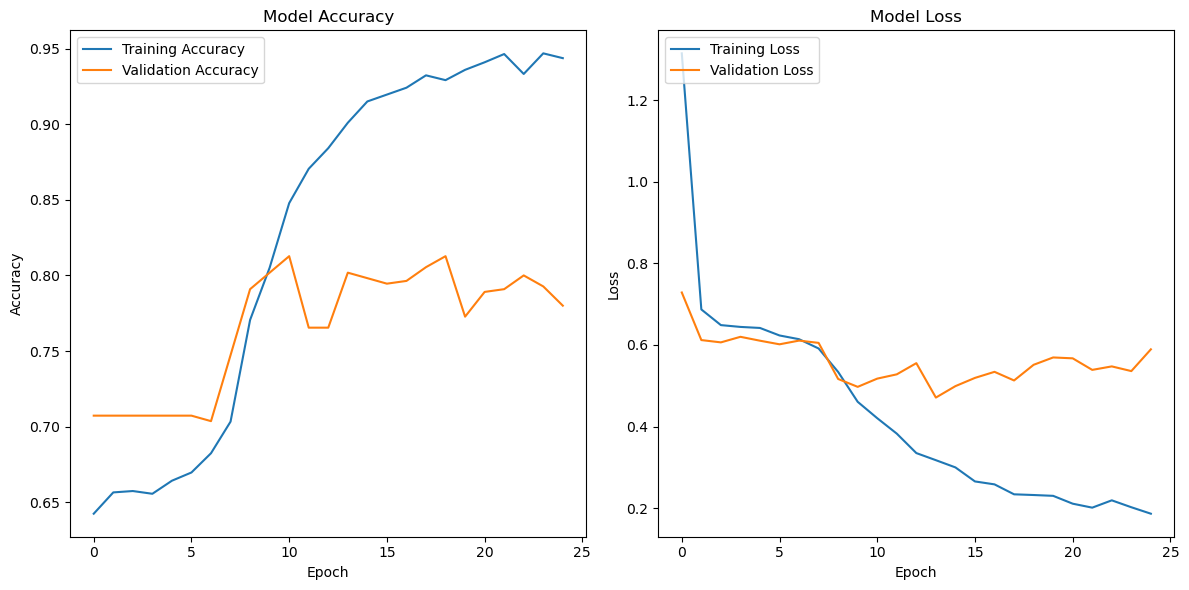

In [26]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
y_pred = model.predict(val_pad_trunc_seq)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Konversi probabilitas menjadi kelas (0 atau 1)

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=['Tidak Depresi', 'Depresi'])
print(report)

18/18 [==============================] - 0s 8ms/step
               precision    recall  f1-score   support

Tidak Depresi       0.87      0.81      0.84       389
      Depresi       0.61      0.71      0.66       161

     accuracy                           0.78       550
    macro avg       0.74      0.76      0.75       550
 weighted avg       0.79      0.78      0.78       550



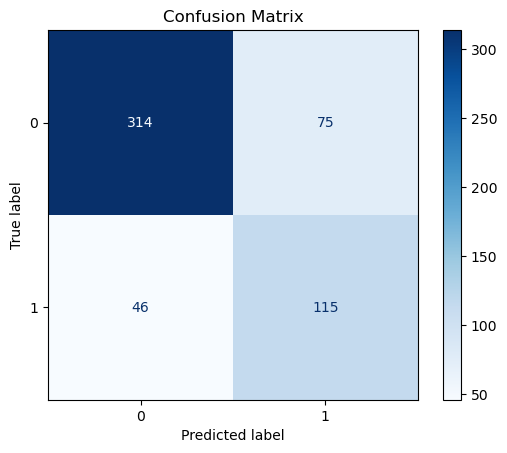

In [28]:
cm = confusion_matrix(y_test, y_pred_classes)

# 3. Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### PREDIKSI

In [29]:
def preprocess_input_text(text):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    pad_trunc_sequence = pad_sequences(sequence, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)
    return pad_trunc_sequence

In [30]:
def predict_text(text):
    processed_text = preprocess_input_text(text)
    prediction = model.predict(processed_text)
    return prediction

In [31]:
input_text = "aku capek sekolah"
prediction = predict_text(input_text)

print(f"Prediksi untuk teks '{input_text}': {prediction[0][0]}")

1/1 [==============================] - 0s 24ms/step
Prediksi untuk teks 'aku capek sekolah': 0.9507640600204468


In [ ]:
model.save("analysis_sentiment_model.h5")

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
